In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA

import umap
import Modules.rnaseqTools as rnaT
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams['xtick.major.width'] = .5
plt.rcParams['ytick.major.width'] = .5

In [2]:
def read_dataset(dataset):
    kwargs = {'sep':'\t', 'header':0, 'index_col':0}
    fname = 'Datasets/%s-tpm.tsv' % dataset
    df = pd.read_csv(fname, **kwargs)
    
    fname = 'Datasets/%s-labels.tsv' % dataset
    df_label = pd.read_csv(fname, **kwargs)
    
    arrays = [df_label.index, df_label.CellType]
    names = ['Cell', 'CellType']
    df.columns = pd.MultiIndex.from_arrays(arrays, names=names)
    
    return df.T

def get_lin_data():
    df_lin = read_dataset('Lab_Pvalb')
    fname = 'Datasets/Lab_Pvalb-transcriptional_labels.tsv'
    kwargs = {'sep':'\t', 'header':0, 'index_col':0}
    df_labels = pd.read_csv(fname, **kwargs)
    df_labels = df_labels.loc[df_lin.index.get_level_values('Cell')]
    
    df_labels = df_labels.loc[df_labels.Age>20]
    df_old = df_lin.loc[df_lin.index.get_level_values('Cell').isin(df_labels.index),:].copy()
    df_young = df_lin.loc[~(df_lin.index.isin(df_old.index)),:].copy()
    
    return df_old, df_young

def get_olm_data():
    df_olm = read_dataset('Lab_OLM')
    df_olm = df_olm.loc[df_olm.index.get_level_values('CellType')=='SST-OLM',:].copy()
    
    return df_olm

def read_data():
    df_old, df_young = get_lin_data()
    df_olm = get_olm_data()
    
    return df_old, df_young, df_olm

def get_markers():
    kwargs = {'sep':'\t', 'header':0, 'index_col':0}
    fname = 'References/marker_ref.txt'
    df_mark = pd.read_csv(fname, **kwargs)
    
    return df_mark

def get_data():
    df_old, df_young, df_olm = read_data()
    df_mark = get_markers()
    
    return df_old, df_young, df_olm, df_mark

def trim_data(df, n=150, min_num=10):
    df = df.loc[:,(df.values>32).sum(axis=0)>=min_num]
    df = df.loc[:,(df.values<0.5).sum(axis=0)>=min_num]
    importantGenes = rnaT.geneSelection(df.values, n=n, threshold=32, plot=False)
    df = np.log2(1+df.loc[:,importantGenes])
    
    return df

def perform_feature_selection(df, trim_num=10):
    df = trim_data(df, min_num=trim_num)
    pca = PCA(n_components=min(50, df.shape[0]))
    datalist = pca.fit_transform(df.values)
    df_pca = pd.DataFrame(datalist, index=df.index)
    
    return df_pca

def embedding_plot(df, ax, df_mark, trim_num=10, to_trim=True, s=70, fname=''):
    if to_trim:
        df_pca = perform_feature_selection(df, trim_num=trim_num)
    else:
        df_pca = df
    reducer = umap.UMAP(n_components=2, n_neighbors=10, min_dist=.01, random_state=42, metric='euclidean')
    plotlist = reducer.fit_transform(df_pca.values)
    
    celltypes = df_pca.index.get_level_values('CellType')
    for celltype in set(celltypes):
        inds = celltypes==celltype
        edge, face, marker = df_mark.loc[celltype]
        ax.scatter(plotlist[inds,0], plotlist[inds,1], edgecolor=edge, facecolor=face, marker=marker, s=s, linewidth=.1)
        
    ax.set_xticks([]), ax.set_yticks([])
    
    if len(fname) > 0:
        df = pd.DataFrame(plotlist, index=df_pca.index, columns=['UMAP X-coordinate', 'UMAP Y-coordinate'])
        df.to_csv(fname, sep='\t')
    
    return

def score_dataframe(df, equalize=False, n=150):
    df_score = pd.DataFrame(np.NaN, index=np.arange(1000), columns=['Train', 'Test'])
    
    if equalize:
        for j in range(10):
            Y = df.index.values
            inds = np.arange(Y.size, dtype=int)
            count_1 = (Y==1).sum()
            count_0 = (Y==0).sum()
            inds_0 = inds[Y==0]
            inds_1 = inds[Y==1]

            if count_1 > count_0:
                inds_sub_1 = np.random.choice(inds_1, size=count_0, replace=False)
                inds = np.hstack((inds_0, inds_sub_1))
            elif count_0 > count_1:
                inds_sub_0 = np.random.choice(inds_0, size=count_1, replace=False)
                inds = np.hstack((inds_sub_0, inds_1))
            df_sub = df.iloc[inds]

            df_sub = trim_data(df_sub, n=n)
            
            X = df_sub.values
            Y = df_sub.index.values
            
            for ind in range(j*100,j*100+100):
                X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)
                clf = RandomForestClassifier(n_estimators=100)
                clf = clf.fit(X_train, Y_train)
                df_score.loc[ind, 'Train'] = clf.score(X_train, Y_train)
                df_score.loc[ind, 'Test'] = clf.score(X_test, Y_test)
    else:
        df = trim_data(df, n=n)
        X = df.values
        Y = df.index.values

        for ind in range(1000):
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)
            clf = RandomForestClassifier(n_estimators=100)
            clf = clf.fit(X_train, Y_train)
            df_score.loc[ind, 'Train'] = clf.score(X_train, Y_train)
            df_score.loc[ind, 'Test'] = clf.score(X_test, Y_test)
    
    return df_score

def get_accuracies(df_old, df_young, df_olm):
    index = ['PV vs SST', 'BIC vs non-BIC', 'BC vs non-BC']
    df_summary = pd.DataFrame(np.NaN, index=index, columns=['Mean', 'Stand_Dev'])
    
    df = pd.concat((df_old, df_olm), axis=0)
    df.index = df.index.get_level_values('CellType').isin(('Htr3a-OLM', 'SST-OLM')).astype(int)
    df_score = score_dataframe(df, equalize=True)
    df_summary.loc['PV vs SST'] = df_score.Test.mean(), df_score.Test.std()
    
    df = df_old.copy()
    df.index = df.index.get_level_values('CellType').isin(('hBC', 'vBC')).astype(int)
    df_score = score_dataframe(df, equalize=True)
    df_summary.loc['BC vs non-BC'] = df_score.Test.mean(), df_score.Test.std()
    
    df = df_old.copy()
    df.index = df.index.get_level_values('CellType').isin(('hBIC', 'vBIC')).astype(int)
    df_score = score_dataframe(df, equalize=True)
    df_summary.loc['BIC vs non-BIC'] = df_score.Test.mean(), df_score.Test.std()
    
    return df_summary

def do_plots(fig, df_mark, df_old, df_young, df_olm):
    ax = fig.add_axes([.10, .7, .22, .17])
    ax.set_title('Pvalb + SST-OLM', fontsize=12)
    df = pd.concat((df_old, df_olm), axis=0)
    fname = 'Mapping/Embeddings/Lab_Pvalb+Lab_OLM.tsv'
    embedding_plot(df, ax, df_mark, s=22.8, fname=fname)
    
    ax = fig.add_axes([.39, .7, .22, .17])
    ax.set_title('Pvalb', fontsize=12)
    fname = 'Mapping/Embeddings/Lab_Pvalb_Only.tsv'
    embedding_plot(df_old, ax, df_mark, s=139.5, fname=fname)
    
    ax = fig.add_axes([.68, .7, .22, .17])
    df_summary = get_accuracies(df_old, df_young, df_olm)
    df_summary.to_csv('Mapping/Separation Accuracy.tsv', sep='\t')
    ax.set_title('Separation Accuracies')
    xvals = np.arange(df_summary.shape[0])+.5
    yvals = df_summary.Mean * 100
    ax.axis([0,df_summary.shape[0],0,100])
    ax.set_ylabel('Accuracy (%)', fontsize=10)
    ax.set_xticks(xvals)
    ax.set_xticklabels(df_summary.index.tolist(), fontsize=6, ha='center', rotation=90)
    ax.tick_params(axis='y', labelsize=6)
    ax.bar(xvals, yvals, edgecolor='#000000', facecolor='#AAAAAA', zorder=0)
    ax.plot([0,df_summary.shape[0]], [50,50], linewidth=1, color='#000000', zorder=1)
    
    return

In [3]:
%%time

df_old, df_young, df_olm, df_mark = get_data()

CPU times: user 441 ms, sys: 25.2 ms, total: 466 ms
Wall time: 495 ms


/home/soma/anaconda3/envs/analyze/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../../../anaconda3/envs/analyze/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/soma/anaconda3/envs/analyze/lib/python3.6/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../../../anaconda3/envs/analyze/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  state.func_ir.loc))
/home/soma/anaconda3/envs/analyze/lib/p

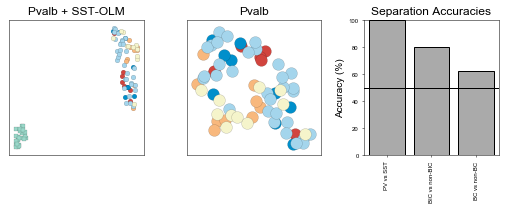

CPU times: user 7min 4s, sys: 2.98 s, total: 7min 7s
Wall time: 7min 5s


In [4]:
%%time

fig = plt.figure(figsize=(8.5,11))
do_plots(fig, df_mark, df_old, df_young, df_olm)
fig.savefig('Figures/Pvalb vs OLM UMAPs.pdf')
plt.show()